# From Multilayer Networks to Deep Graphs

In this tutorial we exemplify the representation of multilayer networks (MLNs) by deep graphs and demonstrate some of the advantages of deepgraph's network representation.

We start by converting the `Noordin Top Terrorist MLN <https://sites.google.com/site/sfeverton18/research/appendix-1>`_ into a graph :py:class:`g <.DeepGraph>` - comprised of two DataFrames, a node table :py:attr:`g.v <.DeepGraph.v>` and an edge table :py:attr:`g.e <.DeepGraph.e>` - that corresponds to the supra-graph representation of the multilayer network.

We then partition the graph ``g`` by the information attributed to its layers, resulting in different supergraphs on the partition lattice of ``g`` that correpsond to different representations of a MLN (including its tensor representation).

In the next part, we demonstrate how additional information that might be at hand or computed during the analysis can be used to induce further supergraphs, or metaphorically speaking, how additional information corresponds to "hidden layers" of a MLN.

Finally, we briefly show how to use the nodes' properties to partition the edges of a MLN.


\*\* **References** \*\*

For a short summary of the multilayer network representation, see Appendix C of the Deep Graphs `paper <https://arxiv.org/pdf/1604.00971v1.pdf>`_.

For a more in-depth introduction to MLNs, I recommend the following papers:

  - `Multilayer Networks <https://arxiv.org/abs/1309.7233>`_ (review paper of MLNs)
  - `The Structure and Dynamics of Multilayer Networks <https://arxiv.org/abs/1407.0742>`_ (review paper of MLNs)
  - `Mathematical Formulation of Multilayer Networks <http://arxiv.org/abs/1307.4977>`_ (tensor formalism for MLNs)

For a discussion of how Deep Graphs relates to the multilayer network representation, see Sec. IV B and Appendix D of the Deep Graphs `paper <https://arxiv.org/pdf/1604.00971v1.pdf>`_.

## The Noordin Top Terrorist Data

The data we use in this tutorial is the `Noordin Top Terrorist Network <https://sites.google.com/site/sfeverton18/research/appendix-1>`_, which has previously been represented as a multilayer network (e.g., http://arxiv.org/abs/1308.3182)

It includes relational data on 79 Indonesian terrorists belonging to the so-called Noordin Top Terrorist Network.

For information about the individual's attributes and their relations, see 
http://www.thearda.com/archive/files/codebooks/origCB/Noordin%20Subset%20Codebook.pdf and 
http://arxiv.org/pdf/1308.3182v3.pdf.

### Preprocessing

We download the data from `here <https://sites.google.com/site/sfeverton18/research/appendix-1>`_, and process it into two pandas `DataFrames <http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html>`_, a node table and an edge table. The preprocessing is quite lengthy, so you might want to proceed directly to the :ref:`next section <skip_preprocessing>`.

First of all, we need to import some packages

In [1]:
# data i/o
import subprocess
import zipfile

# for plots
import matplotlib.pyplot as plt

# the usual
import numpy as np
import pandas as pd

import deepgraph as dg

# notebook display
%matplotlib inline
pd.options.display.max_rows = 10
pd.set_option('expand_frame_repr', False)

### Preprocessing the Nodes

In [2]:
# zip file containing node attributes
get_nodes_zip = ("wget -O tmp/terrorist_nodes.zip "
                 "https://sites.google.com/site/sfeverton18/"
                 "research/appendix-1/Noordin%20Subset%20%28ORA%29.zip?"
                 "attredirects=0&d=1")
subprocess.call(get_nodes_zip.split())

# unzip
zf = zipfile.ZipFile('tmp/terrorist_nodes.zip')
zf.extract('Attributes.csv', path='tmp/')
zf.close()

# create node table
v = pd.read_csv('tmp/Attributes.csv')
v.rename(columns={'Unnamed: 0': 'Name'}, inplace=True)

# create a copy of all nodes for each layer (i.e., create "node-layers")
# there are 10 layers and 79 nodes on each layer
v = pd.concat(10*[v])

# add "aspect" as column to v
layer_names = ['Business', 'Communication', 'O Logistics', 'O Meetings',
               'O Operations', 'O Training', 'T Classmates', 'T Friendship',
               'T Kinship', 'T Soulmates']
layers = [[name]*79 for name in layer_names]
layers = [item for sublist in layers for item in sublist]
v['layer'] = layers

# set unique node index
v.reset_index(inplace=True)
v.rename(columns={'index': 'V_N'}, inplace=True)

# swap columns
cols = list(v)
cols[1], cols[10] = cols[10], cols[1]
v = v.ix[:,cols]

# get rid of the attribute columns for demonstrational purposes,
# will be inserted again later
v, vinfo = v.iloc[:, :2], v.iloc[:, 2:]

### Preprocessing the Edges

In [3]:
# paj file containing edges for different layers
get_paj = ("wget -O tmp/terrorists.paj "
           "https://sites.google.com/site/sfeverton18/"
           "research/appendix-1/Noordin%20Subset%20%28Pajek%29.paj?"
           "attredirects=0&d=1")
subprocess.call(get_paj.split())

# get data blocks from paj file
with open('tmp/terrorists.paj') as txtfile:
    comments = []
    data = []
    part = []
    for line in txtfile:
        if line.startswith('*'):
            # comment lines
            comment = line
            comments.append(comment)
            if part:
                data.append(part)
                part = []
        else:
            # vertices
            if comment.startswith('*Vertices') and len(line.split()) > 1:
                sublist = line.split('"')
                sublist = sublist[:2] + sublist[-1].split()
                part.append(sublist)
            # edges or partitions
            elif len(line) > 1:
                part.append(line.split())
    # append last block
    data.append(part)

# extract edge tables from data blocks
ecomments = []
eparts = []
for i, c in enumerate(comments):
    if c.startswith('*Network'):
        del data[0]
    elif c.startswith('*Partition'):
        del data[0]
    elif c.startswith('*Vector'):
        del data[0]
    elif c.startswith('*Arcs') or c.startswith('*Edges'):
        ecomments.append(c)
        eparts.append(data.pop(0))

# layer data parts (indices found manually via comments)
inds = [11, 10, 5, 6, 7, 8, 0, 1, 2, 3]
eparts = [eparts[ind] for ind in inds]

# convert to DataFrames
layer_frames = []
for name, epart in zip(layer_names, eparts):
    frame = pd.DataFrame(epart, dtype=np.int16)
    # get rid of self-loops, bidirectional edges
    frame = frame[frame[0] < frame[1]]
    # rename columns
    frame.rename(columns={0: 's', 1: 't', 2: name}, inplace=True)
    frame['s'] -= 1
    frame['t'] -= 1
    layer_frames.append(frame)

# set indices
for i, e in enumerate(layer_frames):
    e['s'] += i*79
    e['t'] += i*79
    e.set_index(['s', 't'], inplace=True)

# concat the layers
e = pd.concat(layer_frames)

# edge table as described in the paper
e_paper = e.copy()

In [4]:
# alternative representation of e
e['type'] = 0
e['weight'] = 0
for layer in layer_names:
    where = e[layer].notnull()
    e.loc[where, 'type'] = layer
    e.loc[where, 'weight'] = e.loc[where, layer]
e = e[['type', 'weight']]

## DeepGraph's Supra-Graph Representation of a MLN, $G = (V, E)$

Above, we have processed the downloaded data into a node table ``v`` and an edge table ``e``, that correspond to the supra-graph representation of a multilayer network. This is the preferred representation of a MLN by a deep graph, since all other representations are entailed in the supra-graph's partition lattice, as we will demonstrate below.

In [5]:
g = dg.DeepGraph(v, e)
print(g)

<DeepGraph object, with n=790 node(s) and m=1014 edge(s) at 0x7fb8e13499e8>


Let's have a look at the node table first

In [6]:
print(g.v)

     V_N        layer
0      0     Business
1      1     Business
2      2     Business
3      3     Business
4      4     Business
..   ...          ...
785   74  T Soulmates
786   75  T Soulmates
787   76  T Soulmates
788   77  T Soulmates
789   78  T Soulmates

[790 rows x 2 columns]


As you can see, there are 790 nodes in total. Each of the 10 layers,

In [7]:
print(g.v.layer.unique())

['Business' 'Communication' 'O Logistics' 'O Meetings' 'O Operations'
 'O Training' 'T Classmates' 'T Friendship' 'T Kinship' 'T Soulmates']


is comprised of 79 nodes. Every node has a feature of type ``V_N``, indicating the individual the node belongs to, and a feature of type ``layer``, corresponding to the layer the node belongs to. Each of the 790 nodes corresponds to a node-layer of the MLN representation of this data.

The edge table,

In [8]:
print(g.e)

                type  weight
s   t                       
9   67      Business     2.0
    69      Business     1.0
    77      Business     1.0
11  61      Business     1.0
20  59      Business     1.0
...              ...     ...
733 769  T Soulmates     1.0
755 769  T Soulmates     1.0
    787  T Soulmates     1.0
771 788  T Soulmates     1.0
783 788  T Soulmates     1.0

[1014 rows x 2 columns]


is comprised of 1014 edges between the nodes in ``v``. Each edge has two relations. The first relation (of type ``type``) is determined by the tuple of features :math:`(layer_i, layer_j)` of the adjacent nodes :math:`V_i` and :math:`V_j`. The second relation (of type ``weight``) indicates the "weight" of the connection. 

This representation of the edges of a MLN deviates from the one you can find in the `paper <https://arxiv.org/pdf/1604.00971v1.pdf>`_, which is described in the :ref:`last section <alt_e>`.

There are 10 types of relations in the above edge table

In [9]:
g.e['type'].unique()

array(['Business', 'Communication', 'O Logistics', 'O Meetings',
       'O Operations', 'O Training', 'T Classmates', 'T Friendship',
       'T Kinship', 'T Soulmates'], dtype=object)

which - in the case of this data set - correspond to the layers of the nodes. This is due to the fact that there are no inter-layer connections in the Noordin Top Terrorist Network (such as, e.g., an edge from layer ``Business`` to layer ``Communication`` would be). The edges here are all (undirected) intra-layer edges (e.g., Business $\rightarrow$ Business, Operations $\rightarrow$ Operations).

To see how the edges are distributed among the different types, you can simply type

In [10]:
g.e['type'].value_counts()

O Operations     267
Communication    200
T Classmates     175
O Training       147
T Friendship      91
O Meetings        63
O Logistics       29
T Kinship         16
Business          15
T Soulmates       11
Name: type, dtype: int64

Let's have a look at how many "actors" (nodes with at least one connection) there are within each layer

In [11]:
# append degree
gtg = g.return_gt_graph()
g.v['deg'] = gtg.degree_property_map('total').a

# how many "actors" are there per layer?
g.v[g.v.deg != 0].groupby('layer').size()

layer
Business         13
Communication    74
O Logistics      16
O Meetings       26
O Operations     39
O Training       38
T Classmates     39
T Friendship     61
T Kinship        24
T Soulmates       9
dtype: int64

For the purpose of this tutorial, the fact that the Noordin Top Terrorist Network is a MLN with only one aspect, and without inter-layer edges, is of little importance. The generalization of what we're showing in the following to more general MLNs is straight-forward (and explained in detail in Appendix D of the `paper <https://arxiv.org/pdf/1604.00971v1.pdf>`_).

Let's illustrate the supra-graph representation of this MLN by a plot

/home/macaco/Work/anaconda3/lib/python3.5/site-packages/graph_tool/draw/cairo_draw.py:1468: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


(-1, 791)

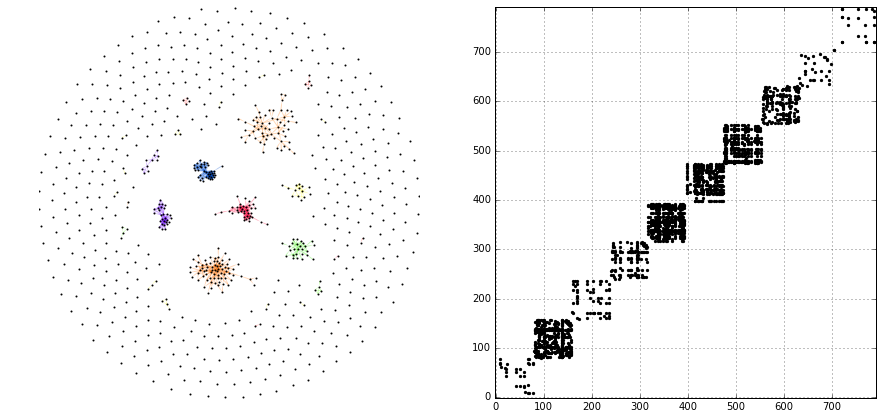

In [12]:
# create graph_tool graph for layout
import graph_tool.draw as gtd
gtg = g.return_gt_graph()
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, gamma=.5)
pos = pos.get_2d_array([0, 1])
g.v['x'] = pos[0]
g.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'s': 1,
                'c': 'k'}

# configure edges
kwds_quiver = {'headwidth': 1,
               'alpha': .3,
               'cmap': 'prism'}
# color by type
C = g.e.groupby('type').grouper.group_info[0]

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
g.plot_2d('x', 'y', edges=True, C=C,
          kwds_scatter=kwds_scatter,
          kwds_quiver=kwds_quiver, ax=ax[0])

# turn axis off, set x/y-lim
ax[0].axis('off')
ax[0].set_xlim((g.v.x.min() - 1, g.v.x.max() + 1))
ax[0].set_ylim((g.v.y.min() - 1, g.v.y.max() + 1))

# plot adjacency matrix
adj = g.return_cs_graph().todense()
adj = adj + adj.T
inds = np.where(adj != 0)
ax[1].scatter(inds[0], inds[1], c='k', marker='.')
ax[1].grid()
ax[1].set_xlim(-1, 791)
ax[1].set_ylim(-1,791)

The supra-graph representation of a MLN is by itself a powerful representation and exploitable in various ways (see, e.g., section 2.3 of this `paper <https://arxiv.org/pdf/1309.7233v4.pdf>`_). However, in the following, we will demonstrate how to use the additional information attributed to the layers of the MLN, in order to "structure" and partition the MLN into different representations.

## Redistributing Information on the Partition Lattice of the MLN

Based on the types of features ``V_N`` and ``layer``, we can now redistribute the information contained in the supra-graph ``g``. This redistribution allows for several representations of the graph, which we will demonstrate in the following.

### The SuperGraph $G^L = (V^L, E^L)$

Partitioning by the type of feature ``layer`` leads to the supergraph $G^L = (V^L,E^L)$, where every supernode $V^{L}_{i^L} \in V^{L}$ corresponds to a distinct layer, encompassing all its respective nodes. Superedges $E^{L}_{i^L, j^L} \in E^{L}$ with either $i^L = j^L$ or $i^L \neq j^L$ correspond to collections of intra- and
inter-layer edges of the MLN, respectively.

In [13]:
# partition the graph
lv, le = g.partition_graph('layer', 
                           relation_funcs={'weight': ['sum', 'mean', 'std']})
lg = dg.DeepGraph(lv, le)
print(lg)

<DeepGraph object, with n=10 node(s) and m=10 edge(s) at 0x7fb8e1349c50>


In [14]:
print(lg.v)

               n_nodes
layer                 
Business            79
Communication       79
O Logistics         79
O Meetings          79
O Operations        79
O Training          79
T Classmates        79
T Friendship        79
T Kinship           79
T Soulmates         79


In [15]:
print(lg.e)

                             n_edges  weight_sum  weight_mean  weight_std
layer_s       layer_t                                                    
Business      Business            15        16.0     1.066667    0.258199
Communication Communication      200       200.0     1.000000    0.000000
O Logistics   O Logistics         29        58.0     2.000000    0.000000
O Meetings    O Meetings          63       170.0     2.698413    1.612801
O Operations  O Operations       267       574.0     2.149813    0.699107
O Training    O Training         147       334.0     2.272109    0.763534
T Classmates  T Classmates       175       175.0     1.000000    0.000000
T Friendship  T Friendship        91        91.0     1.000000    0.000000
T Kinship     T Kinship           16        16.0     1.000000    0.000000
T Soulmates   T Soulmates         11        11.0     1.000000    0.000000


Let's plot the graph ``g`` grouped by its layers.

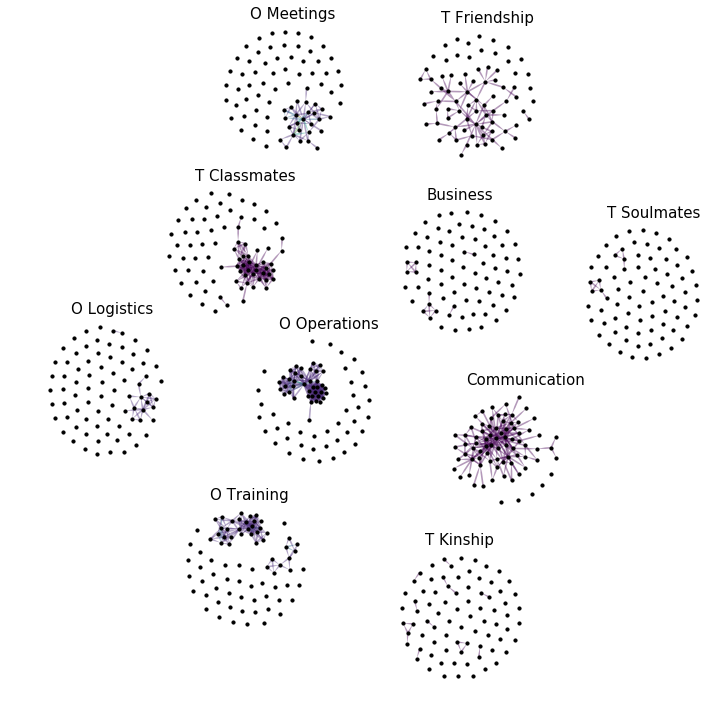

In [16]:
# append layer_id to group nodes by layers
g.v['layer_id'] = g.v.groupby('layer').grouper.group_info[0].astype(np.int32)

# create graph_tool graph object
gtg = g.return_gt_graph(features=['layer_id'])
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, groups=gtg.vp['layer_id'], mu=.15)
pos = pos.get_2d_array([0, 1])
g.v['x'] = pos[0]
g.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'s': 10,
                'c': 'k'}

# configure edges
kwds_quiver = {'headwidth': 1,
               'alpha': .4,
               'cmap': 'viridis'}
# color by weight
C = g.e.weight.values

# plot
fig, ax = plt.subplots(figsize=(12, 12))
obj = g.plot_2d('x', 'y', edges=True, C=C,
          kwds_scatter=kwds_scatter, 
          kwds_quiver=kwds_quiver, ax=ax)

# turn axis off, set x/y-lim and name layers
ax.axis('off')
margin = 10
ax.set_xlim((g.v.x.min() - margin, g.v.x.max() + margin))
ax.set_ylim((g.v.y.min() - margin, g.v.y.max() + margin))
for layer in layer_names:
    plt.text(g.v[g.v['layer'] == layer].x.mean() - margin * 3, 
             g.v[g.v['layer'] == layer].y.max() + margin, 
             layer, fontsize=15)

We can also plot the supergraph $G^L = (V^L, E^L)$

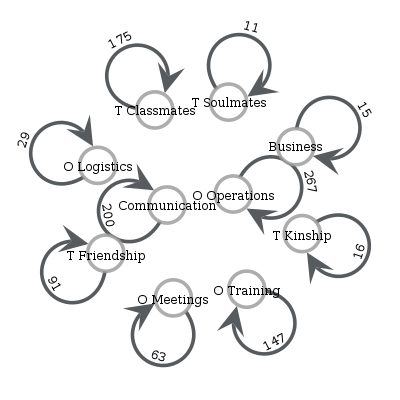

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb8d1db1828, at 0x7fb8d5331ac8>

In [17]:
# create graph_tool graph of lg
gtg = lg.return_gt_graph(relations=True, node_indices=True, edge_indices=True)

# create plot
gtd.graph_draw(gtg, 
               vertex_text=gtg.vp['i'], vertex_text_position=-2, 
               vertex_fill_color='w',
               vertex_text_color='k',
               edge_text=gtg.ep['n_edges'],
               inline=True, fit_view=.8,
               output_size=(400,400))

### The SuperGraph $G^N = (V^N, E^N)$

Partitioning by the type of feature ``V_N`` leads to the supergraph $G^{N} = (V^{N}, E^{N})$, where each supernode $V^{N}_{i^N} \in V^{N}$ corresponds to a node of the MLN. Superedges $E^{N}_{i^N j^N} \in E^{N}$ with $i^N = j^N$ correspond to the coupling edges of a MLN.

In [18]:
# partition by MLN's node indices
nv, ne, gv, ge = g.partition_graph('V_N', return_gve=True)

# for each superedge, get types of edges and their weights
def type_weights(group):
    index = group['type'].values
    data = group['weight'].values
    return pd.Series(data=data, index=index)
ne_weights = ge.apply(type_weights).unstack()
ne = pd.concat((ne, ne_weights), axis=1)

# create graph
ng = dg.DeepGraph(nv, ne)
ng

<DeepGraph object, with n=79 node(s) and m=623 edge(s) at 0x7fb8d1da8b70>

In [19]:
print(ng.v)

     n_nodes
V_N         
0         10
1         10
2         10
3         10
4         10
..       ...
74        10
75        10
76        10
77        10
78        10

[79 rows x 1 columns]


In [20]:
print(ng.e)

             n_edges  Business  Communication  O Logistics  O Meetings  O Operations  O Training  T Classmates  T Friendship  T Kinship  T Soulmates
V_N_s V_N_t                                                                                                                                         
0     15           3       NaN            1.0          2.0         NaN           NaN         NaN           NaN           NaN        1.0          NaN
1     4            1       NaN            NaN          NaN         NaN           NaN         NaN           1.0           NaN        NaN          NaN
      5            1       NaN            NaN          NaN         NaN           NaN         NaN           1.0           NaN        NaN          NaN
      16           1       NaN            NaN          NaN         NaN           2.0         NaN           NaN           NaN        NaN          NaN
      21           1       NaN            NaN          NaN         NaN           NaN         NaN          

Let's plot the graph ``g`` grouped by ``V_N``.

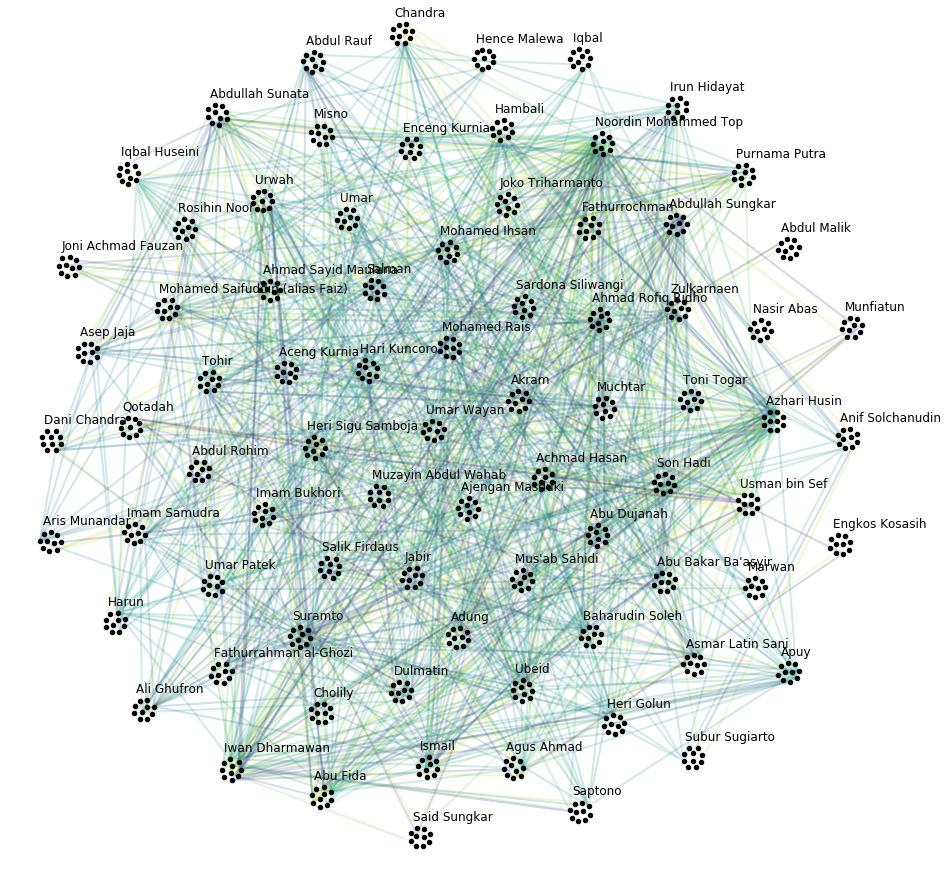

In [21]:
# create graph_tool graph object
g.v['V_N'] = g.v['V_N'].astype(np.int32)  # sfpd only takes int32
g_tmp = dg.DeepGraph(v)
gtg = g_tmp.return_gt_graph(features='V_N')
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, groups=gtg.vp['V_N'], mu=.3, gamma=.01)
pos = pos.get_2d_array([0, 1])
g.v['x'] = pos[0]
g.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'c': 'k'}

# configure edges
kwds_quiver = {'headwidth': 1,
               'alpha': .2,
               'cmap': 'viridis_r'}
# color by type
C = g.e.groupby('type').grouper.group_info[0]

# plot
fig, ax = plt.subplots(figsize=(15,15))
g.plot_2d('x', 'y', edges=True,
          kwds_scatter=kwds_scatter, C=C,
          kwds_quiver=kwds_quiver, ax=ax)

# turn axis off, set x/y-lim and name nodes
name_dic = {i: name for i, name in enumerate(vinfo.iloc[:79].Name)}
ax.axis('off')
ax.set_xlim((g.v.x.min() - 1, g.v.x.max() + 1))
ax.set_ylim((g.v.y.min() - 1, g.v.y.max() + 1))
for node in g.v['V_N'].unique():
    plt.text(g.v[g.v['V_N'] == node].x.mean() - 1,
             g.v[g.v['V_N'] == node].y.max() + 1,
             name_dic[node], fontsize=12)

Let's also plot the supergraph $G^N = (V^N, E^N)$, where the color of the superedges corresponds to the number of edges within the respective superedge.

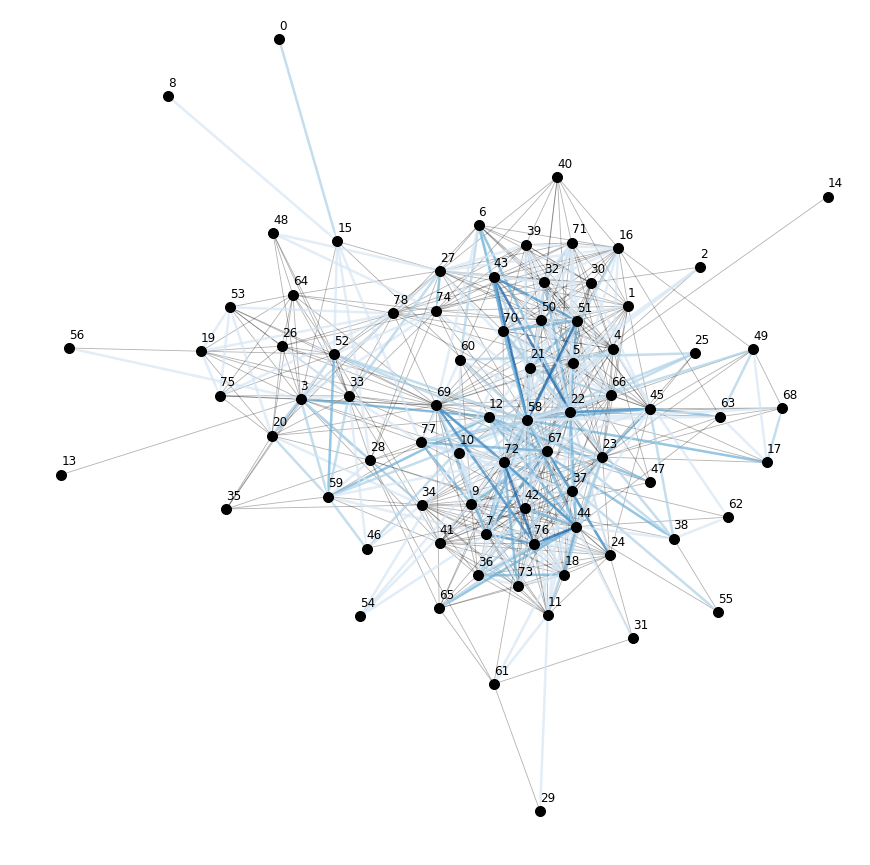

In [22]:
# get rid of isolated node for nicer layout
ng.v.drop(57, inplace=True, errors='ignore')

# create graph_tool graph object
gtg = ng.return_gt_graph(features=True, relations='n_edges')
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg)
pos = pos.get_2d_array([0, 1])
ng.v['x'] = pos[0]
ng.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'s': 100,
                'c': 'k'}

# configure edges
# split edges with only one type of connection
C_split_0 = ng.e['n_edges'].values.copy()
C_split_0[C_split_0 == 1] = 0

# edges with one type of connection
kwds_quiver_0 = {'alpha': .3,
                 'width': .001}

# edges with more than one type
kwds_quiver = {'headwidth': 1,
               'width': .003,
               'alpha': .7, 
               'cmap': 'Blues',
               'clim': (1, ng.e.n_edges.max())}

# create plot
fig, ax = plt.subplots(figsize=(15,15))
ng.plot_2d('x', 'y', edges=True, C_split_0=C_split_0,
           kwds_scatter=kwds_scatter, kwds_quiver_0=kwds_quiver_0, 
           kwds_quiver=kwds_quiver, ax=ax)

# turn axis off, set x/y-lim and name nodes
ax.axis('off')
ax.set_xlim(ng.v.x.min() - 1, ng.v.x.max() + 1)
ax.set_ylim(ng.v.y.min() - 1, ng.v.y.max() + 1)
for i in ng.v.index:
    plt.text(ng.v.at[i, 'x'], ng.v.at[i, 'y'] + .3, i, fontsize=12)

### The Tensor-Like Representation  $G^{NL} = (V^{NL}, E^{NL})$

Considering only the information attributed to the layers of the MLN, and the fact that this MLN has just one aspect, there is only one more supergraph we can create of ``g``. It is given by creating the intersection partition (see section III E of the Deep Graphs `paper <https://arxiv.org/pdf/1604.00971v1.pdf>`_) of the types of features ``V_N`` and ``layer``. The resulting supergraph :math:`G^{N \cdot L} = (V^{N \cdot L},E^{N \cdot L})` corresponds one to one to the graph :math:`G = (V, E)`, and therefore to the supra-graph representation of the MLN. The only difference is the indexing, which is tensor-like for the supergraph :math:`G^{N \cdot L}`.

In [23]:
# partition the graph
relation_funcs = {'type': 'sum', 'weight': 'sum'}  # just to transfer relations
nlv, nle = g.partition_graph(['V_N', 'layer'], relation_funcs=relation_funcs)
nlg = dg.DeepGraph(nlv, nle)
nlg

<DeepGraph object, with n=790 node(s) and m=1014 edge(s) at 0x7fb8d5325550>

In [24]:
print(nlg.v)

                   n_nodes
V_N layer                 
0   Business             1
    Communication        1
    O Logistics          1
    O Meetings           1
    O Operations         1
...                    ...
78  O Training           1
    T Classmates         1
    T Friendship         1
    T Kinship            1
    T Soulmates          1

[790 rows x 1 columns]


In [25]:
print(nlg.e)

                                         n_edges  weight           type
V_N_s layer_s       V_N_t layer_t                                      
0     Communication 15    Communication        1     1.0  Communication
      O Logistics   15    O Logistics          1     2.0    O Logistics
      T Kinship     15    T Kinship            1     1.0      T Kinship
1     O Operations  16    O Operations         1     2.0   O Operations
                    22    O Operations         1     2.0   O Operations
...                                          ...     ...            ...
72    T Soulmates   77    T Soulmates          1     1.0    T Soulmates
73    O Operations  76    O Operations         1     2.0   O Operations
      O Training    76    O Training           1     2.0     O Training
75    O Training    78    O Training           1     2.0     O Training
      T Friendship  78    T Friendship         1     1.0   T Friendship

[1014 rows x 3 columns]


This tensor-like index allows you to use the `advanced indexing <http://pandas.pydata.org/pandas-docs/stable/advanced.html#advanced-indexing-with-hierarchical-index>`_ features of pandas.

In [26]:
print(nlg.e.loc[2, 'Communication', :, 'Communication'])

                                         n_edges  weight           type
V_N_s layer_s       V_N_t layer_t                                      
2     Communication 5     Communication        1     1.0  Communication
                    12    Communication        1     1.0  Communication
                    30    Communication        1     1.0  Communication
                    58    Communication        1     1.0  Communication


In the future, we might implement a method to convert this tensor-representation of a MLN to some sparse-tensor data structure (e.g., https://github.com/mnick/scikit-tensor). Another idea is to create an interface to a suitable multilayer network package that implements the measures and models developed particularly for MLNs.

## The "Hidden Layers" of a MLN

Partitioning a multilayer network solely based on the information attributed to its layers only gets us this far. If there is more information available, or computed during the analysis [e.g., by statistical measures, network measures or similarity/distance measures (see :py:meth:`g.create_edges <.create_edges>`)], it can be used to induce further supergraphs and reach other elements of the partition lattice of ``g``. 

This is what we'll demonstrate here, based on the additional information available about the individual's attributes:

In [27]:
print(vinfo)

     Education Level  Contact with People   Military Training  Nationality  Current Status (ICG Article)  Role  Primary Group Affiliation  Noordin's Network              Name
0                  0                     5                  0            3                             1     7                          1                  0       Abdul Malik
1                  2                     3                  0            3                             2    10                          1                  0        Abdul Rauf
2                  0                    10                  0            3                             1     9                          0                  0       Abdul Rohim
3                  3                     5                  3            3                             2     1                          2                  0   Abdullah Sunata
4                  2                     3                  0            3                             0     1               

As you can see, there are 9 different attributes associated with each individual, such as their military training, nationality, education level, etc. Let's append this information to the node table, and plot the nodes grouped by their education level.

In [28]:
# append node information to g
v = pd.concat((v, vinfo), axis=1)
g = dg.DeepGraph(v, e)

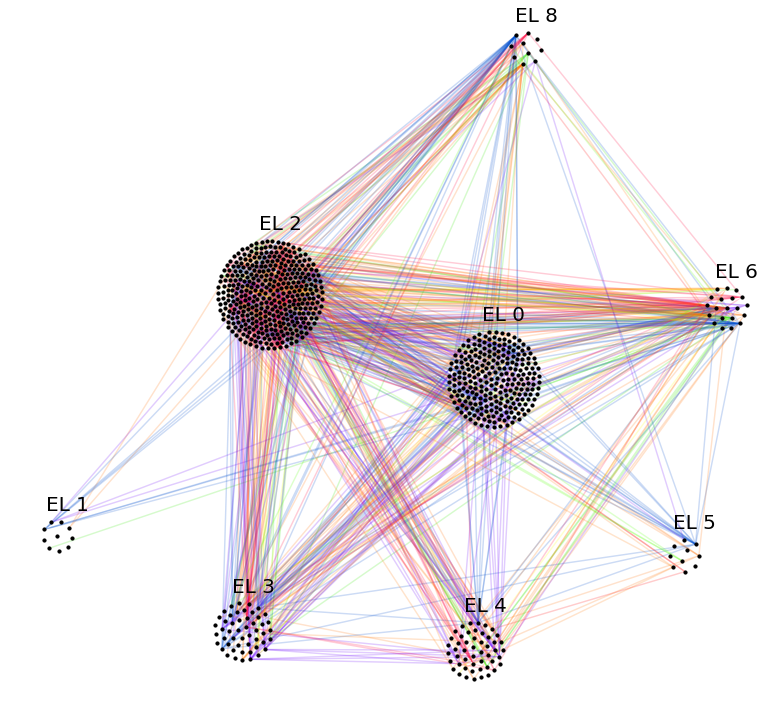

In [29]:
# create graph_tool graph object
g.v['Education Level'] = g.v['Education Level'].astype(np.int32)
g_tmp = dg.DeepGraph(g.v)
gtg = g_tmp.return_gt_graph(features=['Education Level'])
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, groups=gtg.vp['Education Level'], mu=.3, gamma=.1)
pos = pos.get_2d_array([0, 1])
g.v['x'] = pos[0]
g.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'s': 10,
                'c': 'k'}

# configure edges
kwds_quiver = {'width': 0.002,
               'headwidth': 1,
               'alpha': .2,
               'cmap': 'prism'}
# color by type
C = g.e.groupby('type').grouper.group_info[0]

# plot
fig, ax = plt.subplots(figsize=(13,12))
obj = g.plot_2d('x', 'y', edges=True, 
          kwds_scatter=kwds_scatter, C=C,
          kwds_quiver=kwds_quiver, ax=ax)

# turn axis off, set x/y-lim and name layers
ax.axis('off')
ax.set_xlim((g.v.x.min() - 1, g.v.x.max() + 1))
ax.set_ylim((g.v.y.min() - 1, g.v.y.max() + 1))
for el in g.v['Education Level'].unique():
    plt.text(g.v[g.v['Education Level'] == el].x.mean() - 1, 
             g.v[g.v['Education Level'] == el].y.max() + 1, 
             'EL {}'.format(el), fontsize=20)

Let's also append the information to the supergraph $G^N$, and plot this supergraph grouped by education level.

In [30]:
# append info to ng.v
ng.v = pd.concat((ng.v, vinfo[:79]), axis=1)

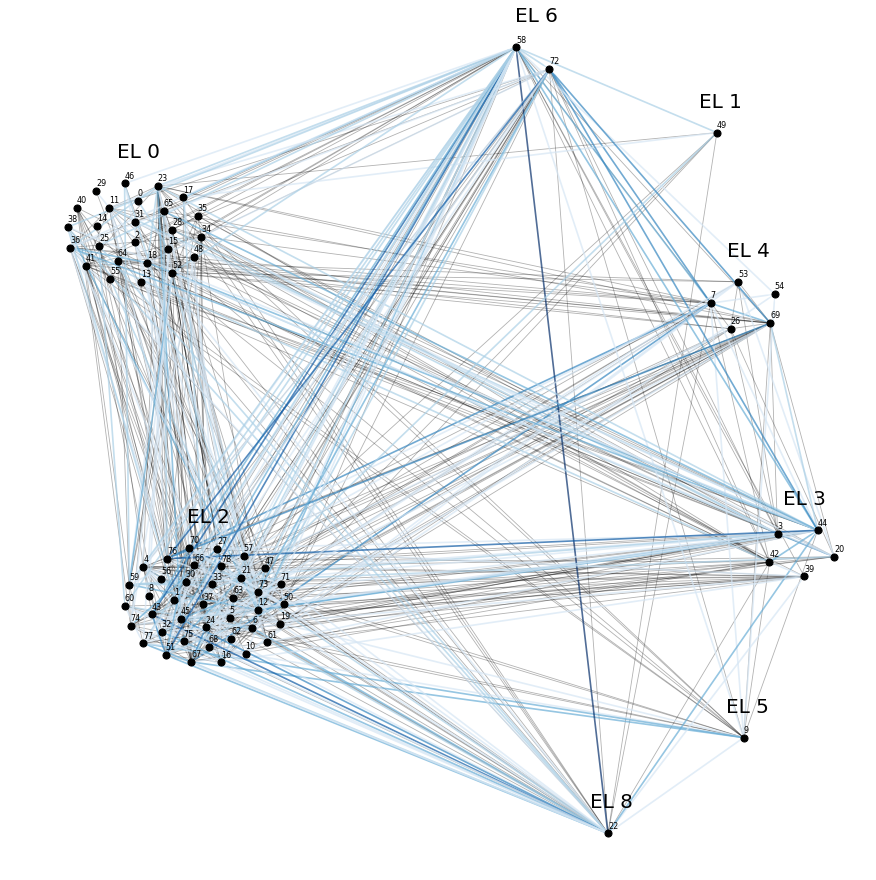

In [31]:
# create graph_tool graph object
ng.v['Education Level'] = ng.v['Education Level'].astype(np.int32)
g_tmp = dg.DeepGraph(ng.v)
gtg = g_tmp.return_gt_graph(features=['Education Level'])
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, groups=gtg.vp['Education Level'], mu=.3, gamma=.01)
pos = pos.get_2d_array([0, 1])
ng.v['x'] = pos[0]
ng.v['y'] = pos[1]

# configure nodes
kwds_scatter = {'s': 50,
                'c': 'k'}

# configure edges
# split edges with only one type of connection
C_split_0 = ng.e['n_edges'].values.copy()
C_split_0[C_split_0 == 1] = 0

# edges with one type of connection
kwds_quiver_0 = {'alpha': .3,
                 'width': .001}

# edges with more than one type
kwds_quiver = {'headwidth': 1,
               'width': .002,
               'alpha': .7, 
               'cmap': 'Blues',
               'clim': (1, ng.e.n_edges.max())}

# create plot
fig, ax = plt.subplots(figsize=(15,15))
obj = ng.plot_2d('x', 'y', edges=True, C_split_0=C_split_0,
                 kwds_scatter=kwds_scatter, kwds_quiver_0=kwds_quiver_0, 
                 kwds_quiver=kwds_quiver, ax=ax)

# turn axis off, set x/y-lim and name nodes
ax.axis('off')
ax.set_xlim(ng.v.x.min() - 1, ng.v.x.max() + 1)
ax.set_ylim(ng.v.y.min() - 1, ng.v.y.max() + 1)
for i in ng.v.index:
    plt.text(ng.v.at[i, 'x'], 
             ng.v.at[i, 'y'] + .2, 
             i, fontsize=8)
    
for el in ng.v['Education Level'].unique():
    plt.text(ng.v[ng.v['Education Level'] == el].x.mean() - .5, 
             ng.v[ng.v['Education Level'] == el].y.max() + 1, 
             'EL {}'.format(el), fontsize=20)

We can now further partition the supergraph $G^N$ into groups with the same education level.

In [32]:
# partition ng by "Education Level"
relation_funcs = {l: lambda x: x.notnull().sum() for l in layer_names}
relation_funcs['n_edges'] = 'sum'
ELnv, ELne = ng.partition_graph('Education Level', 
                                relation_funcs=relation_funcs, 
                                n_edges=False)

# compute "undirected" weights
s = ELne.index.get_level_values(0)
t = ELne.index.get_level_values(1)
df1 = ELne[s <= t]
df2 = ELne[s > t].swaplevel(0,1)
df2.index.names = df2.index.names[::-1]
ELne = df1.add(df2, fill_value=0)

# set dtypes
for col in ELne.columns:
    ELne[col] = ELne[col].astype(int)

# find the type of connection most dominant between supernodes
ELne['dominant_type'] = ELne[layer_names].idxmax(axis=1)

# change column order
ELne = ELne[['n_edges'] + ['dominant_type'] + layer_names]

# create graph
ELng = dg.DeepGraph(ELnv, ELne)
ELng

<DeepGraph object, with n=8 node(s) and m=30 edge(s) at 0x7fb8d1d245c0>

In [33]:
print(ELng.v)

                 n_nodes
Education Level         
0                     25
1                      1
2                     39
3                      5
4                      5
5                      1
6                      2
8                      1


In [34]:
print(ELng.e)

                                     n_edges  dominant_type  Business  Communication  O Logistics  O Meetings  O Operations  O Training  T Classmates  T Friendship  T Kinship  T Soulmates
Education Level_s Education Level_t                                                                                                                                                        
0                 0                       45   O Operations         0              7            2           1            16          15             1             1          2            0
                  1                        3   O Operations         0              0            0           0             2           1             0             0          0            0
                  2                      146   O Operations         1             31            3           7            43          32             9            16          4            0
                  3                       60     O Training 

Let's plot the supergraph of education levels, where the node size relates to the number of individuals, edge colors correspond to the number of edges, and edge labels correspond to the most dominant type of connection between nodes.

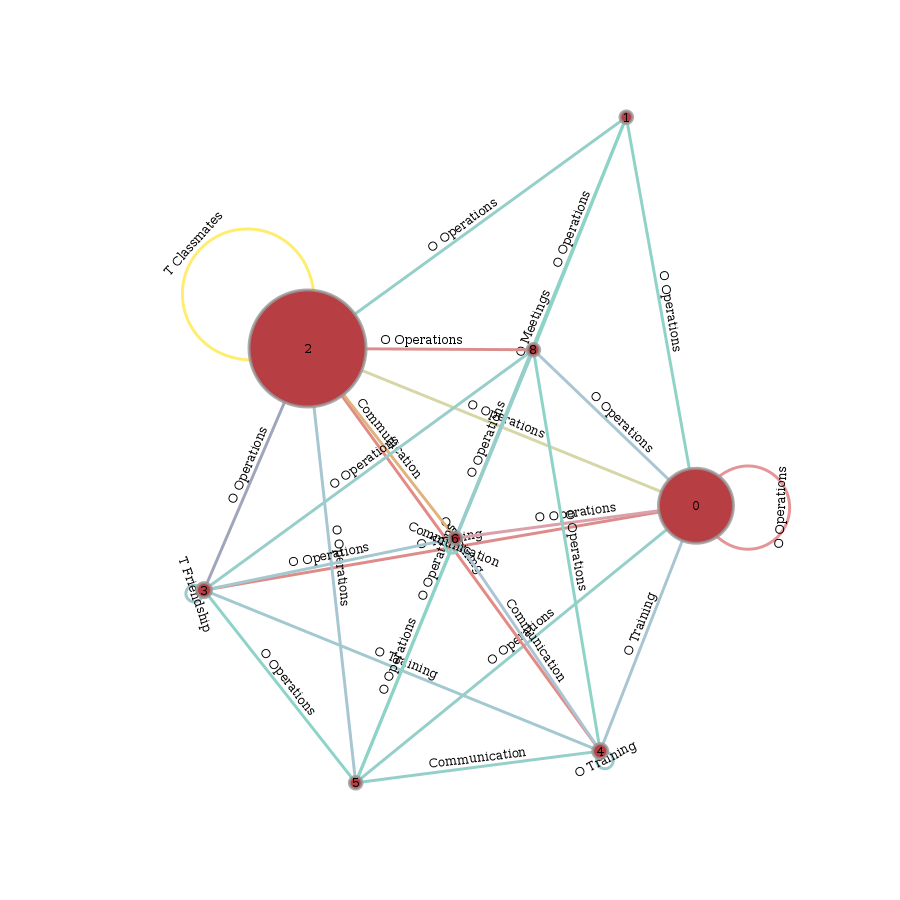

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb8c06c3240, at 0x7fb8c065b240>

In [35]:
# create graph_tool graph object
gtg = ELng.return_gt_graph(features=True, relations=True, node_indices=True)
gtg.set_directed(False)

# get sfdp layout postitions
pos = gtd.sfdp_layout(gtg, 
                      vweight=gtg.vp['n_nodes'], 
                      eweight=gtg.ep['n_edges'])
pos = pos.get_2d_array([0, 1])

# create plot
gtg.vp['n_nodes'].a *= 3
gtd.graph_draw(gtg, 
               vertex_text=gtg.vp['i'],
               vertex_text_color='k', vertex_size=gtg.vp['n_nodes'],
               edge_text=gtg.ep['dominant_type'], 
               edge_color=gtg.ep['n_edges'],
               inline=True, output_size=(900,900), fit_view=True)

## Partitioning Edges Based on Node Properties

Here, we demonstrate very briefly how to use the additional information of the nodes to perform queries on the edges.

In [36]:
# create "undirected" edge table (swap-copy all edges)
g.e = pd.concat((e, e.swaplevel(0,1)))
g.e.sort_index(inplace=True)

In [37]:
print(g.partition_edges(source_features=['Nationality']))

               n_edges
Nationality_s         
3                 1655
4                  351
5                   22


In [38]:
print(g.partition_edges(source_features=['Nationality'], 
                        target_features=['Military Training']))

                                   n_edges
Nationality_s Military Training_t         
3             0                        185
              1                         51
              3                        847
              4                         60
              5                        115
...                                    ...
5             4                          3
              5                          1
              7                          1
              9                          1
              10                         1

[26 rows x 1 columns]


In [39]:
print(g.partition_edges(source_features=['Nationality'], 
                        target_features=['Military Training'], 
                        relations='type'))

                                               n_edges
type        Nationality_s Military Training_t         
Business    3             0                          3
                          3                         16
                          4                          1
                          9                          2
                          10                         2
...                                                ...
T Soulmates 3             9                          1
                          10                         2
            4             3                          3
                          9                          1
                          10                         3

[138 rows x 1 columns]


## Alternative Representation of the MLN Edges

The edges of the supra-graph representation as presented in the paper look like this

In [40]:
print(e_paper)

         Business  Communication  O Logistics  O Meetings  O Operations  O Training  T Classmates  T Friendship  T Kinship  T Soulmates
s   t                                                                                                                                  
9   67        2.0            NaN          NaN         NaN           NaN         NaN           NaN           NaN        NaN          NaN
    69        1.0            NaN          NaN         NaN           NaN         NaN           NaN           NaN        NaN          NaN
    77        1.0            NaN          NaN         NaN           NaN         NaN           NaN           NaN        NaN          NaN
11  61        1.0            NaN          NaN         NaN           NaN         NaN           NaN           NaN        NaN          NaN
20  59        1.0            NaN          NaN         NaN           NaN         NaN           NaN           NaN        NaN          NaN
...           ...            ...          ...   

As you can see, the edge table is also comprised of 1014 edges between the nodes in ``v``. However, every type of connection get's its own column, where a "nan" value means that an edge does not have a relation of the corresponding type. 